# 基本数据集操作和统计

我们介绍一些基本的辅助函数，用于稀疏矩阵的汇总和统计

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')

In [5]:
expm = em.load_experiment('expression', load_samples = False, load_subset = 'mono-neutro')

[!] samples are not dumped in the experiment directory.


In [16]:
print(expm)

annotated data of size 10160 × 19389
subset mono-neutro of size 10160 × 19389
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> cell.type <cat> score <f64> potency <cat> relative <f64> score.preknn <f64>
          potency.preknn <cat> ppt.pseudotime <f64> ppt.seg <cat> ppt.edge <cat>
          ppt.milestones <cat> atlas.batch <cat> kde.umap <f64>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool> n.umi <f64> symbol <cat>
 layers : counts <f32> magic <f64> norm <f32>
   obsm : c

### 分群比例统计

计算数据集行（细胞）对于分类变量的比例， major 指定主行， minor 指定分类变量

In [6]:
expm.run_rna_proportion(
    major = 'sample', minor = 'cell.type',
    normalize = 'index'
)

cell.type,DCp,MDP,MM,Mac,Mast,Mo,Neu,Prog,iMac
sample,,,,,,,,,
distal,0.019303,0.030619,0.082316,0.031507,0.004438,0.037719,0.76592,0.027069,0.001109
niche,0.001337,0.009696,0.072551,0.074557,0.039786,0.138081,0.52658,0.026078,0.111334
normal,0.062359,0.044703,0.057851,0.026672,0.009767,0.126597,0.65402,0.015026,0.003005


### 高斯核密度估计

给定一个低维表示，我们可以计算散点分布的密度

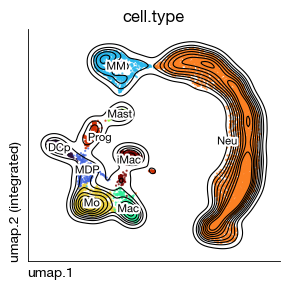

In [7]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'cell.type',
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', annotate_fontsize = 8, contour_plot = True
)

In [10]:
expm.run_rna_kde(
    basis = "umap",
    groupby = "sample",
    key_added = "kde.umap",
    components = "1,2"
)

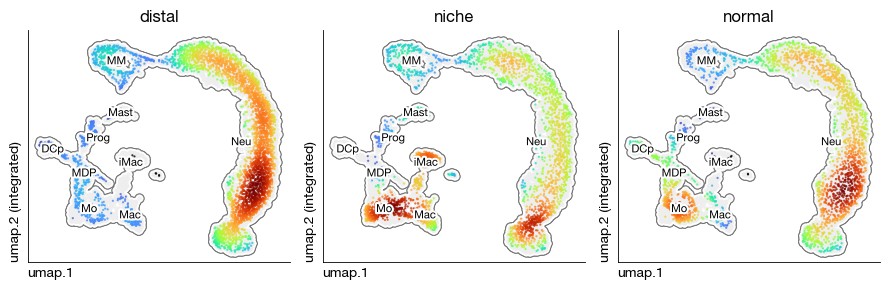

In [12]:
kde = expm.plot_rna_kde(
    basis = 'umap', kde = 'kde.umap', grouping_key = 'sample', 
    background = 'cell.type', annotate = True, annotate_fontsize = 8, ptsize = 2,
    figsize = (9, 3), dpi = 100, groups = None, ncols = 3, cmap = 'turbo'
)

### 汇总统计

汇总统计根据 `on`, `across` 和 `split` 参数创建一个三维的表，表格中每个单元格的值根据 `data`, `orient`, `method`
参数进行计算。返回的表格是一个 anndata 类型，其行对应 `on`, 列对应 `across`，而 `layers` 包含每个 `split`.

如果 `orient` 设置未 'obs', `on`, `across`, `split` 必须是三个 `obs` 表的列，同理当 `orient` 设置为 'var'，
`on`, `across`, `split` 必须是三个 `var` 表的列，特定的行或列被三个筛选条件节选出来，受到 `method` 函数的作用，
成为三维表单元格的值，若筛选结果是空集，对应的单元格是 NaN.

当 `method` 设置为魔术方法 `n` 时，返回对应观察对象的个数（行或列，而不是统计范围的值的个数）

In [32]:
adata = expm.run_rna_summary(
    data = 'X', method = 'n', method_args = {},
    orient = 'obs', on = 'sample', 
    across = 'cell.type', split = 'sample', 
    attached_metadata_on = None, attached_metadata_across = None,
    attach_method_on = 'first', attach_method_across = 'first'
)

In [34]:
em.pd.DataFrame(
    adata.layers['niche'],
    index = adata.obs_names,
    columns = adata.var_names
)

,Neu,Mo,MM,Mac,iMac,MDP,DCp,Prog,Mast
distal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
niche,1575.0,413.0,217.0,223.0,333.0,29.0,4.0,78.0,119.0
normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 聚合统计（伪批次）

聚合统计按照行或列收缩原始数据表。当 data 设置为原始计数，而 method 设置为 sum 时，这个作用
常常用于生成虚拟批量 RNA 数据

In [23]:
adata = expm.run_rna_aggregate(
    data = 'counts', method = 'sum', method_args = {},
    obs_key = 'sample', var_key = None
)

In [29]:
em.pd.DataFrame(
    adata.X,
    index = adata.obs_names,
    columns = adata.var['gene']
).iloc[:, 0:10]

gene,Bzw1,Ppp1r9b,Samd14,Clk1,Pdk2,Itga3,Ppil3,Tac4,Kat7,Gm11520
distal,4186.0,1693.0,28.0,6743.0,58.0,0.0,463.0,2.0,1590.0,144.0
niche,4201.0,2829.0,41.0,5438.0,54.0,10.0,477.0,6.0,1552.0,115.0
normal,3509.0,1576.0,22.0,4872.0,72.0,1.0,452.0,8.0,1309.0,128.0
